In [5]:
import shap
import pandas as pd
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from alibi.explainers import AnchorTabular
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")

/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-16 17:01:00.479070: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
import sys
import os
sys.path.append(os.path.abspath('/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine'))

from utils.helper import *
failures = load_failures_data('../data/model_data/failures.csv')
components = failures['component'].unique()
component_data = load_all_component_data(components)
data_splits = prepare_all_data_for_training(component_data, "target_class")
models = load_all_models(components, "xgb")
selected_features_data = fit_and_select_features(models, data_splits)
models = retrain_models_on_selected_features(models, selected_features_data, data_splits)

In [10]:
for component in components:
    globals()[f"{component}_explainer"] = shap.TreeExplainer(models[component])
    globals()[f"{component}_shap_values"] = globals()[f"{component}_explainer"].shap_values(selected_features_data[component][1])

In [13]:
shap.initjs()
shap.force_plot(GENERATOR_BEARING_explainer.expected_value, GENERATOR_BEARING_shap_values[0,:], selected_features_data['GENERATOR_BEARING'][1].iloc[0,:])

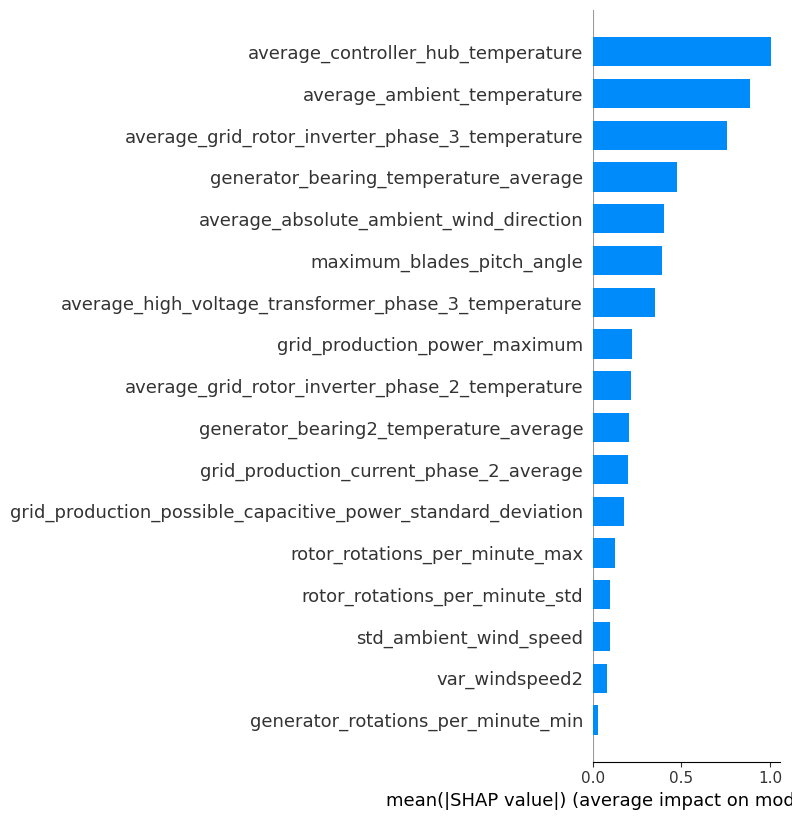

In [15]:
shap.summary_plot(GEARBOX_shap_values, selected_features_data['GEARBOX'][1], plot_type="bar")

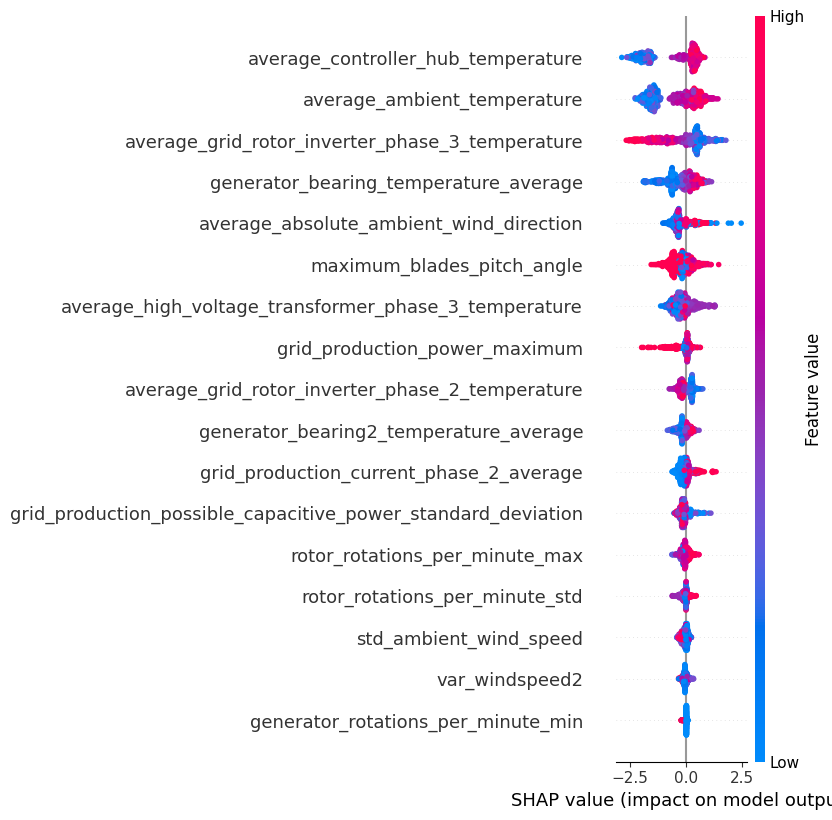

In [17]:
shap.summary_plot(GEARBOX_shap_values, selected_features_data['GEARBOX'][1])

In [36]:
classes = models['GEARBOX'].classes_.tolist()

# Save SHAP Values as JSON


In [57]:
import json

all_components_shap_values = {}

for component in components:
    num_rows = len(selected_features_data[component][1])  # Assuming this is 729
    num_features = len(selected_features_data[component][2])  # Assuming this is 17

    component_shap_values = {}
    for i in range(num_features):
        feature_name = selected_features_data[component][2][i]
        shap_values_sum = float(globals()[f"{component}_shap_values"][:, i].sum())  # Adjust the array variable
        
        # Store feature name and sum of SHAP values in the component dictionary
        component_shap_values[feature_name] = shap_values_sum
    
    # Store component's SHAP values dictionary in the main dictionary
    all_components_shap_values[component] = component_shap_values

json_data = json.dumps(all_components_shap_values, indent=4)

with open('shap_values.json', 'w') as f:
    f.write(json_data)